In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat_trainmode import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

from scipy.stats import norm

from genesis.vae import *

def load_data(data_name, valid_set_size=0.05, test_set_size=0.05, batch_size=32) :
    
    #Load cached dataframe
    cached_dict = pickle.load(open(data_name, 'rb'))
    plasmid_df = cached_dict['plasmid_df']
    plasmid_cuts = cached_dict['plasmid_cuts']

    #Generate training and test set indexes
    plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

    plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
    plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
    plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]


    data_gens = {
        gen_id : iso.DataGenerator(
            idx,
            {'df' : plasmid_df},
            batch_size=batch_size,
            inputs = [
                {
                    'id' : 'seq',
                    'source_type' : 'dataframe',
                    'source' : 'df',
                    'extractor' : lambda row, index: row['padded_seq'][180 + 40: 180 + 40 + 81] + "G" * (128-81),
                    'encoder' : iso.OneHotEncoder(seq_length=128),
                    'dim' : (1, 128, 4),
                    'sparsify' : False
                }
            ],
            outputs = [
                {
                    'id' : 'dummy_output',
                    'source_type' : 'zeros',
                    'dim' : (1,),
                    'sparsify' : False
                }
            ],
            randomizers = [],
            shuffle = True if gen_id == 'train' else False
        ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
    }

    x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
    x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)
    
    return x_train, x_test


Using TensorFlow backend.


In [3]:
#Specfiy problem-specific parameters

#Padding for the VAE
vae_upstream_padding = ''
vae_downstream_padding = 'G' * 47

#VAE sequence template
vae_sequence_template = 'ATCCANNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCC' + 'G' * (128 - 81)

#VAE latent dim
vae_latent_dim = 100

#Oracle predictor model path
saved_predictor_model_path = '../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

#Subtring indices for VAE
vae_pwm_start = 40
vae_pwm_end = 121


VAE Model = strong_very_high_kl_epoch_20


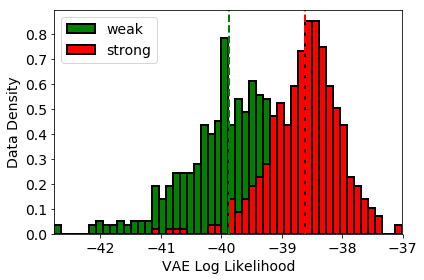

VAE Model = strong_very_high_kl_epoch_28


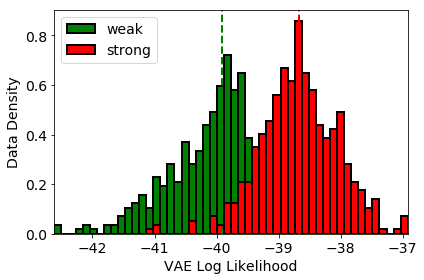

VAE Model = strong_very_high_kl_epoch_35


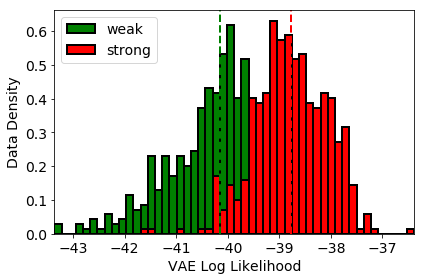

VAE Model = strong_very_high_kl_epoch_50


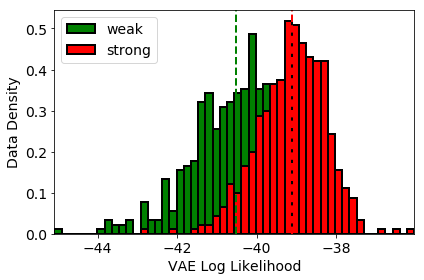

In [4]:
#Evaluate ELBO distribution on test sets of different quantiles of data, using the strong-APA-biased VAE

data_set_paths = [
    "vae/apa_doubledope_cached_set_weak_short_cano_pas.pickle",
    "vae/apa_doubledope_cached_set_strong_short_cano_pas.pickle"
]

data_set_names = [
    'weak',
    'strong'
]

data_set_colors = [
    'green',
    'red'
]

vae_model_paths = [
    "vae/saved_models/vae_apa_max_isoform_doubledope_strong_cano_pas_len_128_50_epochs_very_high_kl",
    "vae/saved_models/vae_apa_max_isoform_doubledope_strong_cano_pas_len_128_50_epochs_very_high_kl",
    "vae/saved_models/vae_apa_max_isoform_doubledope_strong_cano_pas_len_128_50_epochs_very_high_kl",
    "vae/saved_models/vae_apa_max_isoform_doubledope_strong_cano_pas_len_128_50_epochs_very_high_kl"
]

vae_model_suffixes = [
   "_epoch_20",
    "_epoch_28",
    "_epoch_35",
    ""
]

vae_model_names = [
    "strong_very_high_kl_epoch_20",
    "strong_very_high_kl_epoch_28",
    "strong_very_high_kl_epoch_35",
    "strong_very_high_kl_epoch_50"
]

n_max = 500

for vae_model_ix, vae_model_path in enumerate(vae_model_paths) :
    
    #Load VAE models
    print("VAE Model = " + vae_model_names[vae_model_ix])
    
    vae_encoder_model = load_model(vae_model_path + "_encoder" + vae_model_suffixes[vae_model_ix] + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
    vae_decoder_model = load_model(vae_model_path + "_decoder" + vae_model_suffixes[vae_model_ix] + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

    log_mean_p_vae_tests = []
    for data_set_ix, data_set_path in enumerate(data_set_paths) :
        
        #Load data set
        x_train, x_test = load_data(data_set_path, valid_set_size=0.005, test_set_size=0.095)
        
        #Compute multi-sample ELBO on test set
        log_mean_p_vae_test, _, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test[:n_max], n_samples=128)
        
        log_mean_p_vae_tests.append(log_mean_p_vae_test)
    
    plot_joint_histo(
        log_mean_p_vae_tests,
        data_set_names,
        data_set_colors,
        'VAE Log Likelihood',
        'Data Density',
        n_bins=50,
        figsize=(6, 4),
        save_fig=False,
        fig_name="kl_den_apa_max_iso_vae_likelihood_model_" + vae_model_names[vae_model_ix]
    )



VAE Model = weak_very_high_kl_epoch_20


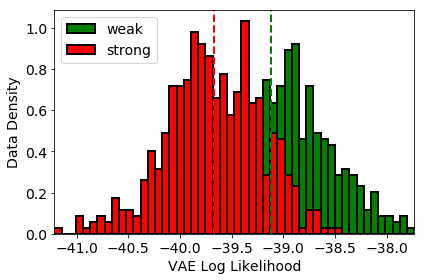

VAE Model = weak_very_high_kl_epoch_28


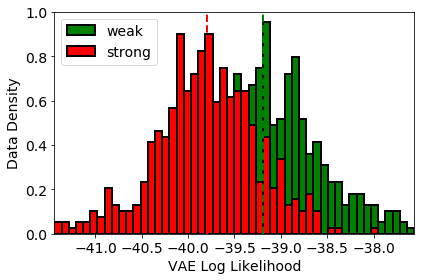

VAE Model = weak_very_high_kl_epoch_35


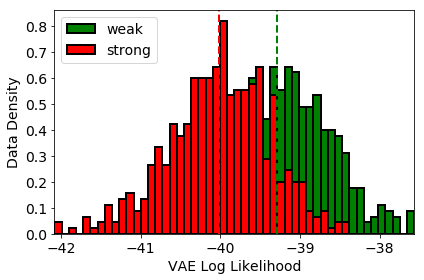

VAE Model = weak_very_high_kl_epoch_50


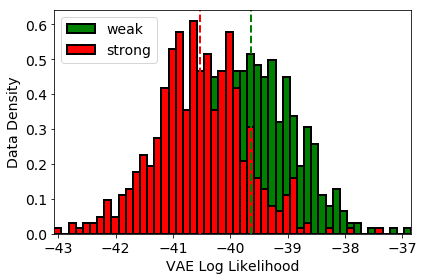

In [5]:
#Evaluate ELBO distribution on test sets of different quantiles of data, using the weak-APA-biased VAE

data_set_paths = [
    "vae/apa_doubledope_cached_set_weak_short_cano_pas.pickle",
    "vae/apa_doubledope_cached_set_strong_short_cano_pas.pickle"
]

data_set_names = [
    'weak',
    'strong'
]

data_set_colors = [
    'green',
    'red'
]

vae_model_paths = [
    "vae/saved_models/vae_apa_max_isoform_doubledope_weak_cano_pas_len_128_50_epochs_very_high_kl_2",
    "vae/saved_models/vae_apa_max_isoform_doubledope_weak_cano_pas_len_128_50_epochs_very_high_kl_2",
    "vae/saved_models/vae_apa_max_isoform_doubledope_weak_cano_pas_len_128_50_epochs_very_high_kl_2",
    "vae/saved_models/vae_apa_max_isoform_doubledope_weak_cano_pas_len_128_50_epochs_very_high_kl_2"
]

vae_model_suffixes = [
    "_epoch_20",
    "_epoch_28",
    "_epoch_35",
    ""
]

vae_model_names = [
    "weak_very_high_kl_epoch_20",
    "weak_very_high_kl_epoch_28",
    "weak_very_high_kl_epoch_35",
    "weak_very_high_kl_epoch_50"
]

n_max = 500

for vae_model_ix, vae_model_path in enumerate(vae_model_paths) :
    
    #Load VAE models
    print("VAE Model = " + vae_model_names[vae_model_ix])
    
    vae_encoder_model = load_model(vae_model_path + "_encoder" + vae_model_suffixes[vae_model_ix] + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
    vae_decoder_model = load_model(vae_model_path + "_decoder" + vae_model_suffixes[vae_model_ix] + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

    log_mean_p_vae_tests = []
    for data_set_ix, data_set_path in enumerate(data_set_paths) :
        
        #Load data set
        x_train, x_test = load_data(data_set_path, valid_set_size=0.005, test_set_size=0.095)
        
        #Compute multi-sample ELBO on test set
        log_mean_p_vae_test, _, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test[:n_max], n_samples=128)
        
        log_mean_p_vae_tests.append(log_mean_p_vae_test)
    
    plot_joint_histo(
        log_mean_p_vae_tests,
        data_set_names,
        data_set_colors,
        'VAE Log Likelihood',
        'Data Density',
        n_bins=50,
        figsize=(6, 4),
        save_fig=False,
        fig_name="kl_den_apa_max_iso_vae_likelihood_model_" + vae_model_names[vae_model_ix]
    )



VAE Model = weak


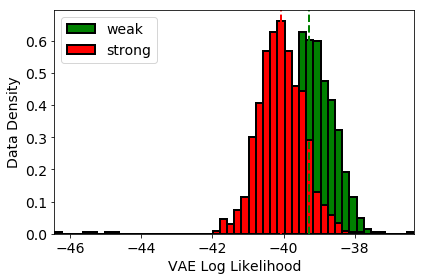

VAE Model = strong


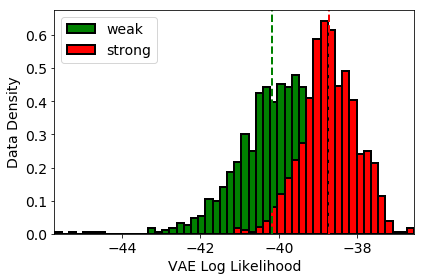

In [11]:
#Evaluate ELBO distribution on test sets of different quantiles of data

data_set_paths = [
    "vae/apa_doubledope_cached_set_weak_short_cano_pas.pickle",
    "vae/apa_doubledope_cached_set_strong_short_cano_pas.pickle"
]

data_set_names = [
    'weak',
    'strong'
]

data_set_colors = [
    'green',
    'red'
]

vae_model_paths = [
    "vae/saved_models/vae_apa_max_isoform_doubledope_weak_cano_pas_len_128_50_epochs_very_high_kl_2",
    "vae/saved_models/vae_apa_max_isoform_doubledope_strong_cano_pas_len_128_50_epochs_very_high_kl"
]

vae_model_suffixes = [
    "_epoch_35", #_epoch_28,_epoch_50 
    "_epoch_35" #_epoch_28, _epoch_50
]

vae_model_names = [
    "weak",
    "strong"
]

n_max = 1000

for vae_model_ix, vae_model_path in enumerate(vae_model_paths) :
    
    #Load VAE models
    vae_encoder_model = load_model(vae_model_path + "_encoder" + vae_model_suffixes[vae_model_ix] + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
    vae_decoder_model = load_model(vae_model_path + "_decoder" + vae_model_suffixes[vae_model_ix] + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

    log_mean_p_vae_tests = []
    for data_set_ix, data_set_path in enumerate(data_set_paths) :
        
        #Load data set
        x_train, x_test = load_data(data_set_path, valid_set_size=0.005, test_set_size=0.095)
        
        #Compute multi-sample ELBO on test set
        log_mean_p_vae_test, _, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test[:n_max], n_samples=128)
        
        log_mean_p_vae_tests.append(log_mean_p_vae_test)
    
    
    print("VAE Model = " + vae_model_names[vae_model_ix])
    
    plot_joint_histo(
        log_mean_p_vae_tests,
        data_set_names,
        data_set_colors,
        'VAE Log Likelihood',
        'Data Density',
        n_bins=50,
        figsize=(6, 4),
        save_fig=False,
        fig_name="kl_den_apa_max_iso_vae_likelihood_model_" + vae_model_names[vae_model_ix]
    )


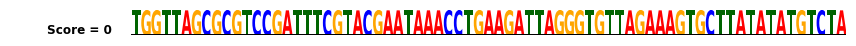

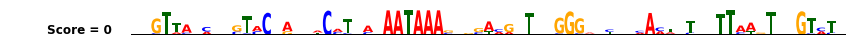

---


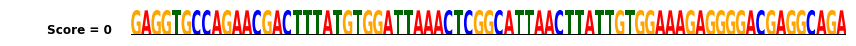

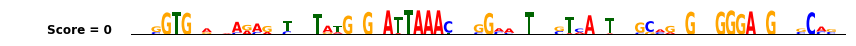

---


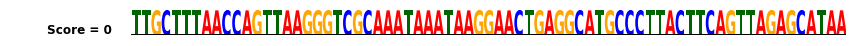

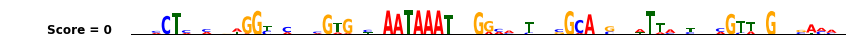

---


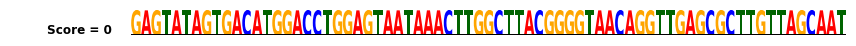

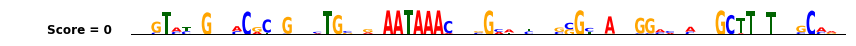

---


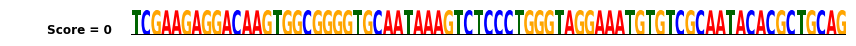

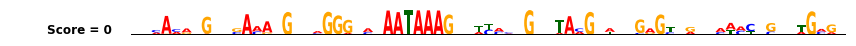

---


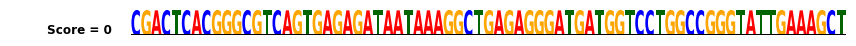

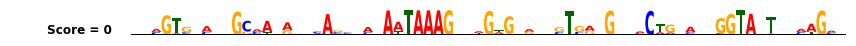

---


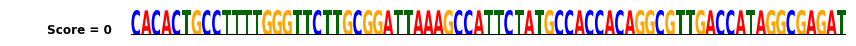

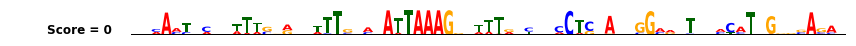

---


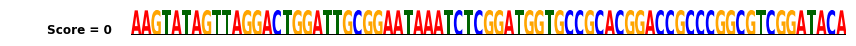

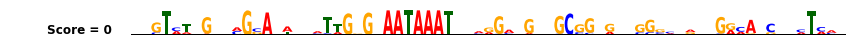

---


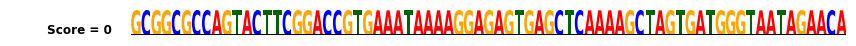

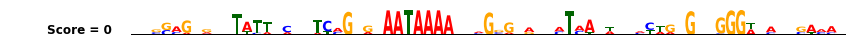

---


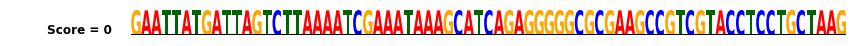

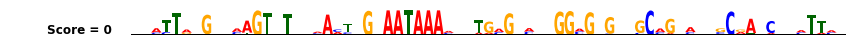

---


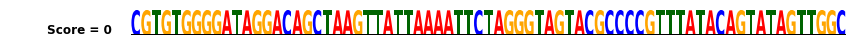

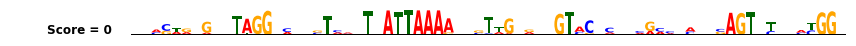

---


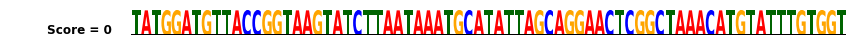

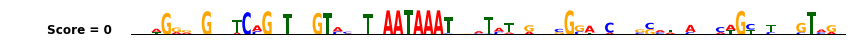

---


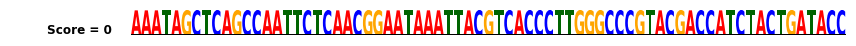

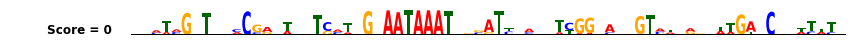

---


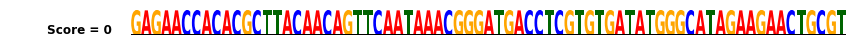

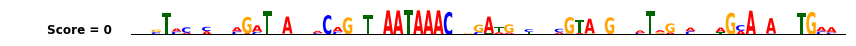

---


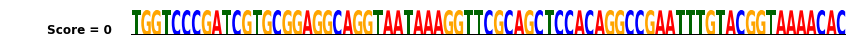

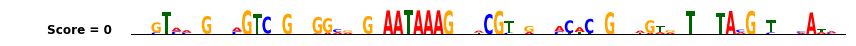

---


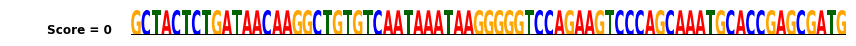

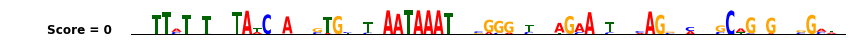

---


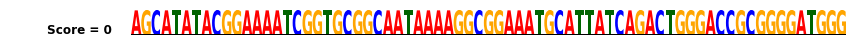

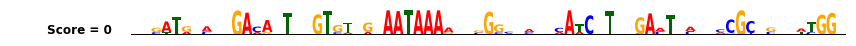

---


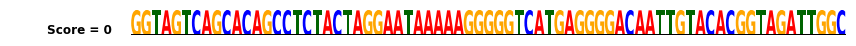

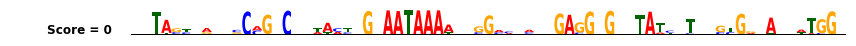

---


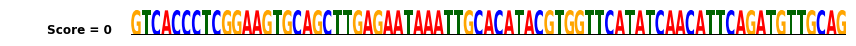

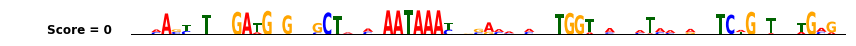

---


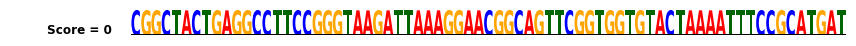

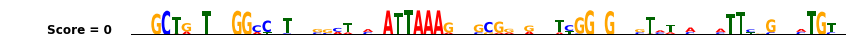

---


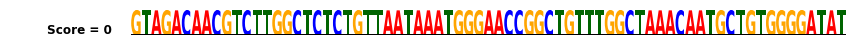

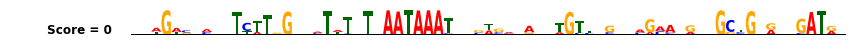

---


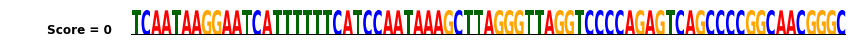

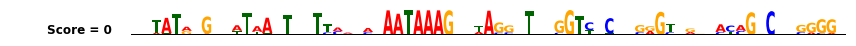

---


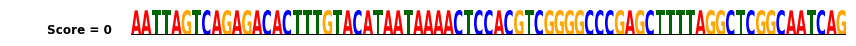

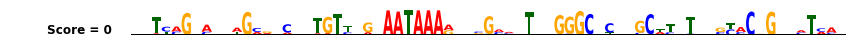

---


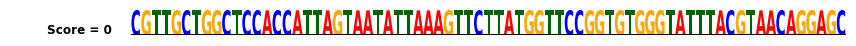

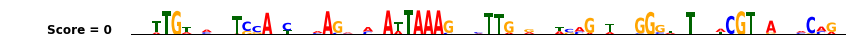

---


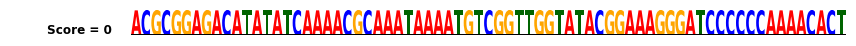

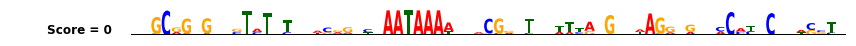

---


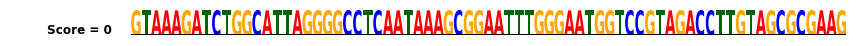

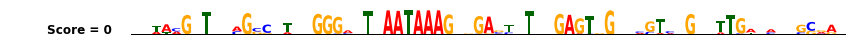

---


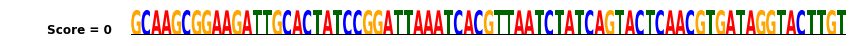

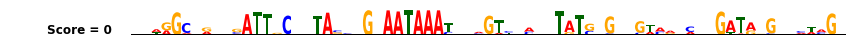

---


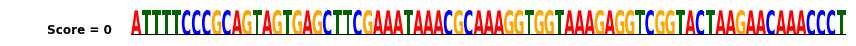

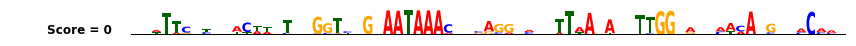

---


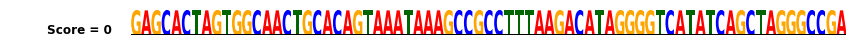

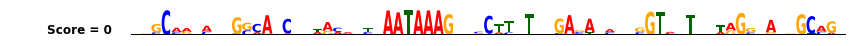

---


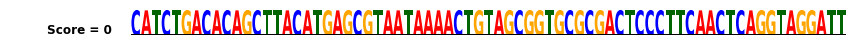

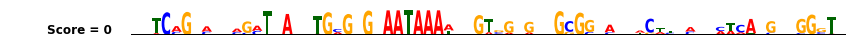

---


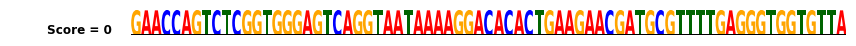

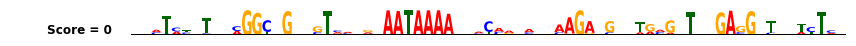

---


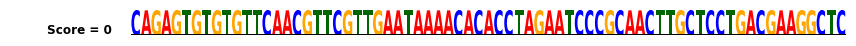

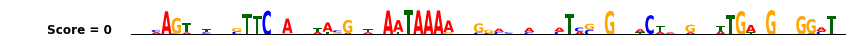

---


In [9]:
#Visualize decoder for weak quantile

vae_model_path = "vae/saved_models/vae_apa_max_isoform_doubledope_weak_cano_pas_len_128_50_epochs_very_high_kl_2"
vae_model_suffix = ""#"_epoch_35"
vae_data_path = "vae/apa_doubledope_cached_set_weak_short_cano_pas.pickle"

#Load VAE models
vae_encoder_model = load_model(vae_model_path + "_encoder" + vae_model_suffix + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(vae_model_path + "_decoder" + vae_model_suffix + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

#Load data set
_, x_test = load_data(vae_data_path, valid_set_size=0.005, test_set_size=0.095)

#Run VAE models on data
_, _, z_test = vae_encoder_model.predict(x=[x_test], batch_size=32, verbose=False)
_, decoded_pwm_test, _ = vae_decoder_model.predict(x=[np.zeros((z_test.shape[0], 1)), z_test], batch_size=32, verbose=False)

for plot_i in range(32) :
    plot_gan_logo(x_test[plot_i, 0, :, :], 0, sequence_template=vae_sequence_template, figsize=(12, 0.75), width_ratios=[1, 7], logo_height=1.0, plot_start=5, plot_end=81-5)
    plot_gan_logo(decoded_pwm_test[plot_i, 0, :, :], 0, sequence_template=vae_sequence_template, figsize=(12, 0.75), width_ratios=[1, 7], logo_height=1.0, plot_start=5, plot_end=81-5)
    print("---")


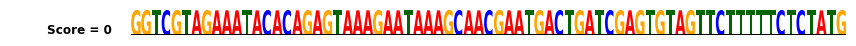

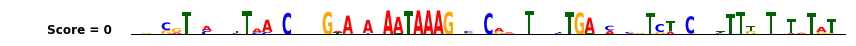

---


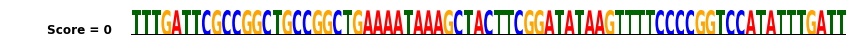

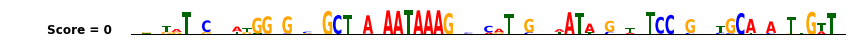

---


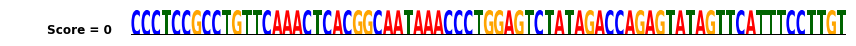

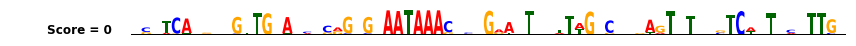

---


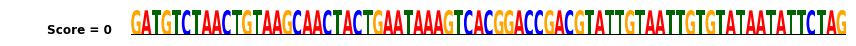

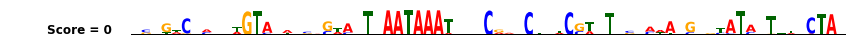

---


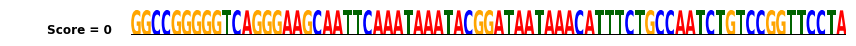

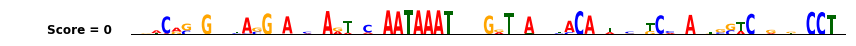

---


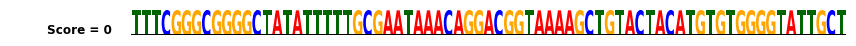

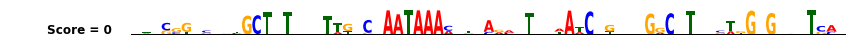

---


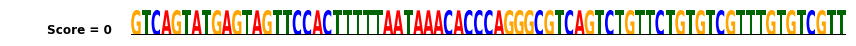

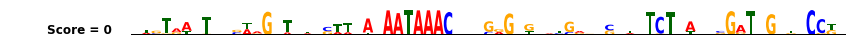

---


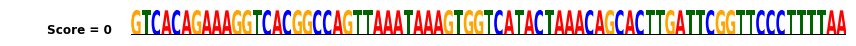

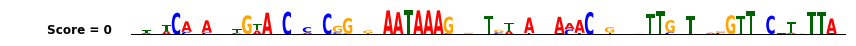

---


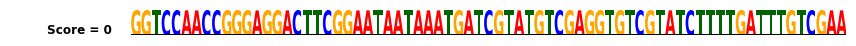

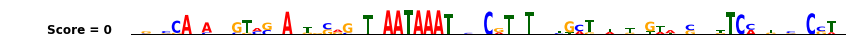

---


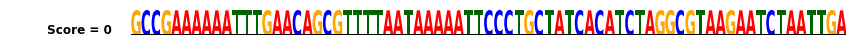

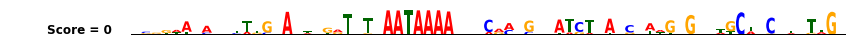

---


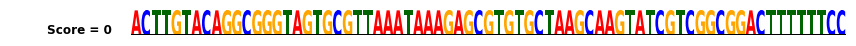

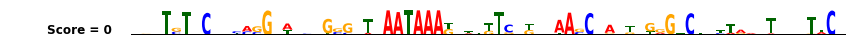

---


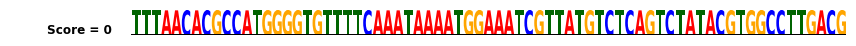

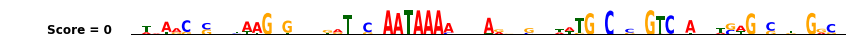

---


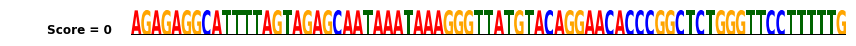

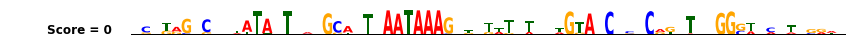

---


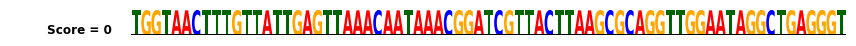

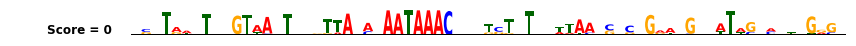

---


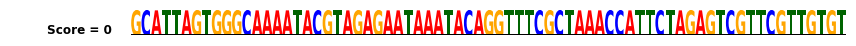

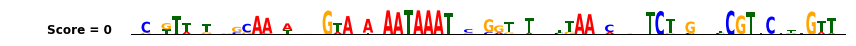

---


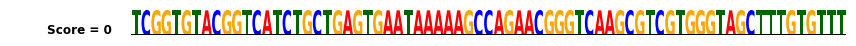

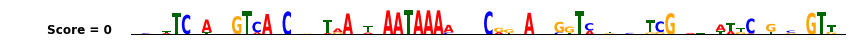

---


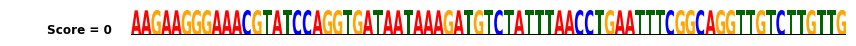

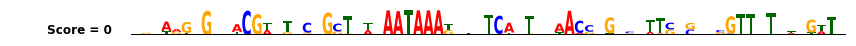

---


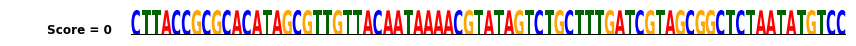

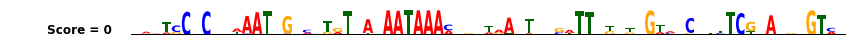

---


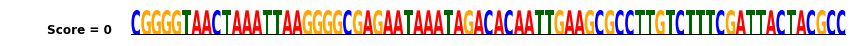

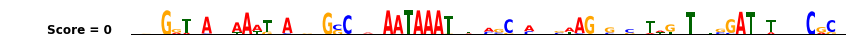

---


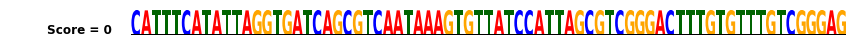

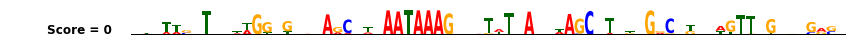

---


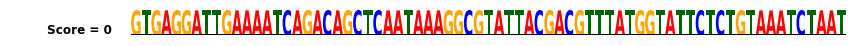

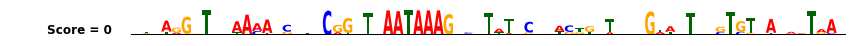

---


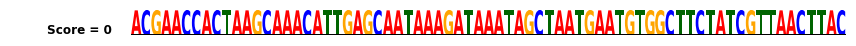

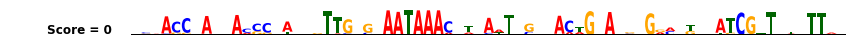

---


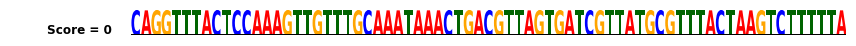

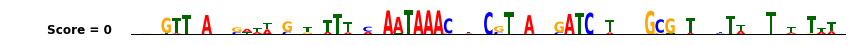

---


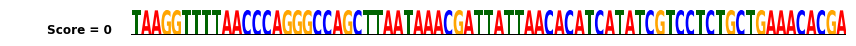

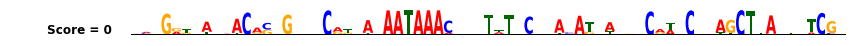

---


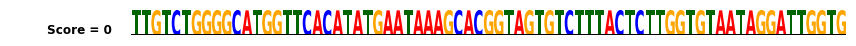

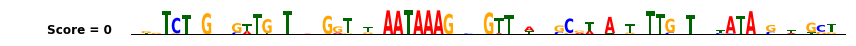

---


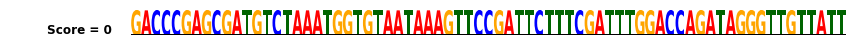

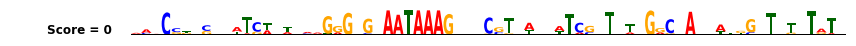

---


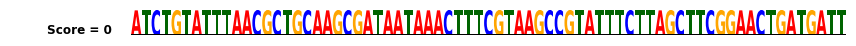

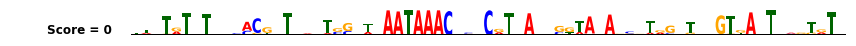

---


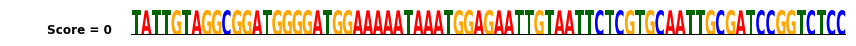

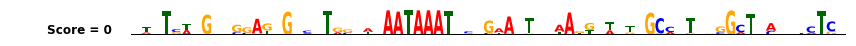

---


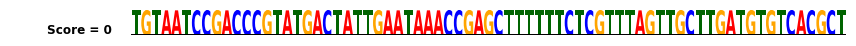

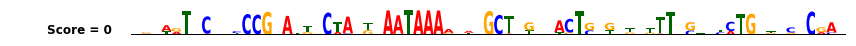

---


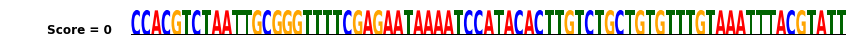

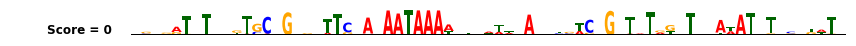

---


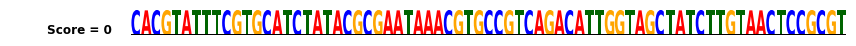

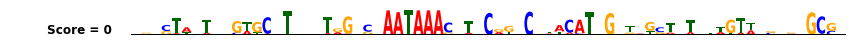

---


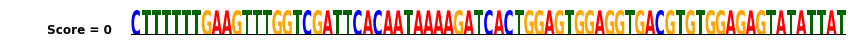

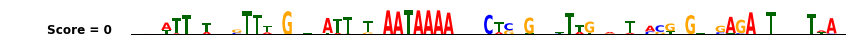

---


In [8]:
#Visualize decoder for strong quantile

vae_model_path = "vae/saved_models/vae_apa_max_isoform_doubledope_strong_cano_pas_len_128_50_epochs_very_high_kl"
vae_model_suffix = ""#"_epoch_35"
vae_data_path = "vae/apa_doubledope_cached_set_strong_short_cano_pas.pickle"

#Load VAE models
vae_encoder_model = load_model(vae_model_path + "_encoder" + vae_model_suffix + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(vae_model_path + "_decoder" + vae_model_suffix + ".h5", custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

#Load data set
_, x_test = load_data(vae_data_path, valid_set_size=0.005, test_set_size=0.095)

#Run VAE models on data
_, _, z_test = vae_encoder_model.predict(x=[x_test], batch_size=32, verbose=False)
_, decoded_pwm_test, _ = vae_decoder_model.predict(x=[np.zeros((z_test.shape[0], 1)), z_test], batch_size=32, verbose=False)

for plot_i in range(32) :
    plot_gan_logo(x_test[plot_i, 0, :, :], 0, sequence_template=vae_sequence_template, figsize=(12, 0.75), width_ratios=[1, 7], logo_height=1.0, plot_start=5, plot_end=81-5)
    plot_gan_logo(decoded_pwm_test[plot_i, 0, :, :], 0, sequence_template=vae_sequence_template, figsize=(12, 0.75), width_ratios=[1, 7], logo_height=1.0, plot_start=5, plot_end=81-5)
    print("---")
